In [23]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn as skl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
import time

In [24]:
!pip3 install nbformat


%run "datasets/parse.ipynb"
train_df = parse_train("")
test_df = parse_test("")

In [25]:
categorical_to_numerical = {
    'Injecao na rede (kWh)': {
        'None': 0,
        'Low': 1,
        'Medium': 2,
        'High':3,
        'Very High':4
    },
    'weather_description': {
        'overcast clouds': 0,
        'scattered clouds': 1,
        'few clouds': 2,
        'sky is clear': 3,
        'broken clouds': 4,
        'light rain': 5,
        'moderate rain': 6,
        'heavy intensity rain':7
    }
}

numeric_columns = ['Hora', 'Normal (kWh)', 'Horario Economico (kWh)', 'Autoconsumo (kWh)', 'temp','feels_like','temp_min','temp_max','pressure','humidity', 'wind_speed','clouds_all','rain_1h']


def data_preparation(df: pd.DataFrame,test_or_train) -> pd.DataFrame:
    prep_df= df
    prep_df['rain_1h'] = prep_df['rain_1h'].replace('', '0')
    prep_df['rain_1h'] = pd.to_numeric(prep_df['rain_1h'])
            
    ### Converter as features categoricas em numericas
    prep_df.replace(categorical_to_numerical, inplace=True)

    ### Extrair a hora e dia da semana da feature 'record_date'
    record_date = pd.DatetimeIndex(prep_df['Data'])

    prep_df['Month'] = record_date.month
    prep_df['Day'] = record_date.day
    prep_df['Year'] = record_date.year

    dropped_columns = ['grnd_level','sea_level','dt','Data','city_name']
    prep_df = prep_df.drop(dropped_columns, axis=1)

    prep_df.loc[(prep_df['Hora'] < 6) & (prep_df['Hora'] > 21), 'Injecao na rede (kWh)'] = 0

    whiskers = []
    for num in numeric_columns:
        Q1 = prep_df[num].quantile(0.25)
        Q3 = prep_df[num].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        whiskers.append((num,lower,upper))

    ### Tratar os outliers das features numéricas:
    ### Substituir os valores dos outliers pela mediana
    if(train_test_split == "train"):
        for num, lower, upper in whiskers:
            prep_df = prep_df[(prep_df[num] >= lower) & (prep_df[num] <= upper)]

    return prep_df

In [26]:
X = data_preparation(train_df,"train")
test_df = data_preparation(test_df,"test").drop('Injecao na rede (kWh)',axis=1)


In [27]:
y = X['Injecao na rede (kWh)']
X = X.drop('Injecao na rede (kWh)', axis=1)

In [28]:
starttime= time.process_time()

logmodel1 = LogisticRegression(random_state=25112002,solver='newton-cg',max_iter=1000)
print(logmodel1)
logmodel1.fit(X,np.ravel(y))

endtime= time.process_time()
print(f"Time spent: {endtime-starttime} seconds")
predictions1= logmodel1.predict(X)

LogisticRegression(max_iter=1000, random_state=25112002, solver='newton-cg')
Time spent: 5.421875 seconds


In [29]:
starttime= time.process_time()

logmodel2 = LogisticRegression(random_state=25112002,solver='lbfgs',max_iter=1000)
print(logmodel2)
logmodel2.fit(X,np.ravel(y))

endtime= time.process_time()
print(f"Time spent: {endtime-starttime} seconds")
predictions2= logmodel2.predict(X)

LogisticRegression(max_iter=1000, random_state=25112002)
Time spent: 2.328125 seconds


c:\Desktop\miniconda3\envs\mypython3version\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [30]:
starttime= time.process_time()

logmodel3 = LogisticRegression(random_state=25112002,solver='liblinear',max_iter=1000)
print(logmodel3)
logmodel3.fit(X,np.ravel(y))

endtime= time.process_time()
print(f"Time spent: {endtime-starttime} seconds")
predictions3= logmodel3.predict(X)

LogisticRegression(max_iter=1000, random_state=25112002, solver='liblinear')
Time spent: 0.421875 seconds


In [31]:


predictions= logmodel3.predict(test_df)

predictions_df = pd.DataFrame(predictions)

numerical_to_categorical = {
    0: {
        0 : 'None',
        1 : 'Low',
        2 : 'Medium',
        3 : 'High',
        4 : 'Very High'
    }
}

predictions_df.replace(numerical_to_categorical, inplace=True)

predictions_df.index += 1

predictions_df.to_csv("submission.csv", header=['Result'], index_label='RowId')

In [32]:
print("With 'newton-cg': \n",classification_report(y,predictions1))
print("With 'lbfgs': \n",classification_report(y,predictions2))
print("With 'liblinear': \n",classification_report(y,predictions3))

With 'newton-cg': 
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      1654
           1       0.00      0.00      0.00        87
           2       0.55      0.63      0.59       241
           3       0.58      0.65      0.62       213
           4       0.74      0.33      0.45        61

    accuracy                           0.86      2256
   macro avg       0.57      0.52      0.53      2256
weighted avg       0.83      0.86      0.84      2256

With 'lbfgs': 
               precision    recall  f1-score   support

           0       0.80      0.98      0.88      1654
           1       0.00      0.00      0.00        87
           2       0.41      0.10      0.15       241
           3       0.49      0.36      0.42       213
           4       0.60      0.05      0.09        61

    accuracy                           0.77      2256
   macro avg       0.46      0.30      0.31      2256
weighted avg       0.69      0.77      0.

c:\Desktop\miniconda3\envs\mypython3version\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Desktop\miniconda3\envs\mypython3version\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Desktop\miniconda3\envs\mypython3version\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

<function matplotlib.pyplot.show(close=None, block=None)>

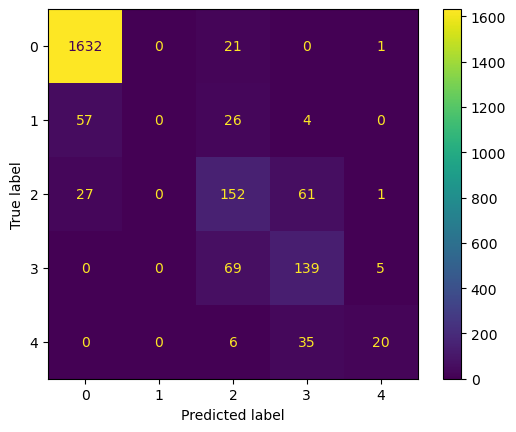

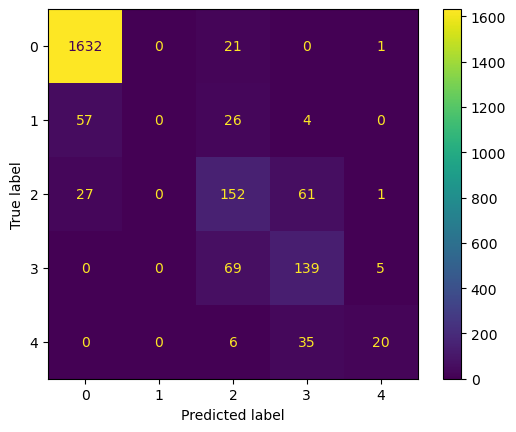

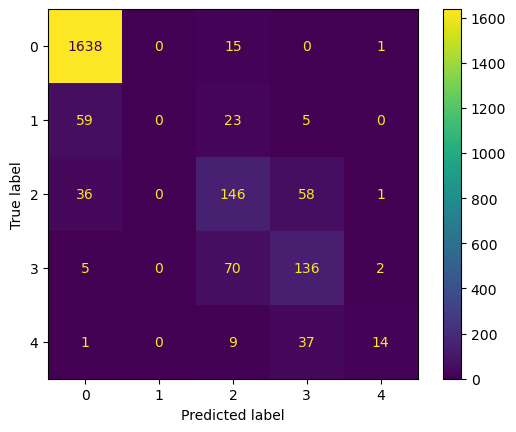

In [33]:

ConfusionMatrixDisplay.from_predictions(y, predictions1)
ConfusionMatrixDisplay.from_predictions(y, predictions1)
ConfusionMatrixDisplay.from_predictions(y, predictions3)
plt.show